In [1]:
import numpy as np
import emcee
import astropy.coordinates as coord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import scipy.stats as stats
from plot_traces import *
from credible import *
import corner
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import pygtc

In [395]:
def log_likelihood(theta, clusters, s_obs, z, nct_params, d_ref, kT_scale):
    
    '''
    Takes in: 
    DATA - arrays of cluster names, best-fit scaling factors, redshifts, nct fit parameters, reference
    cosmology, kT scaling factors
    MODEL PARAMETERS - floats H0, intrinsic scatter (encompasses fit scatter), kT bias, overall fit bias + flux bias
    
    Computes:
    For each cluster, the likelihood that the observed scaling factor corresponds to a cosmology with a Hubble 
    constant of H0 (w/ other given model parameters)
    
    Returns:
    Sum of the log-likelihood of all clusters
    '''
    
    H0, intr_scatter, kT_bias, f_bias = theta
    
    if (H0 <= 0) or (H0 > 200) or (intr_scatter <= 0.01):
        return -np.inf
    
    # For intrinsic scatter, use prior proportional to 1/sig --> log(1/sig) = log(1) - log(sig) = -log(sig) lmfao math
    log_prior = -np.log(intr_scatter)
    
    # Normal kT bias & overall bias priors
    log_prior += stats.norm.logpdf(kT_bias, loc=0.09, scale=0.13)
    log_prior += stats.norm.logpdf(f_bias, loc=0.024, scale=0.026)
    
    # Riess 2019 prior for H0
    #log_prior += stats.norm.logpdf(H0, loc=74.03, scale=1.42)
    
    # Planck 2018 prior for H0
    #log_prior += stats.norm.logpdf(H0, loc=67.4, scale=0.5)
    
    total_likelihood = 0
    
    # Trial cosmology using input H0
    trial_cosmo = FlatLambdaCDM(H0=H0, Om0=0.3) 
    
    for i in range(0, 12):

        # Compute d(z) according to trial cosmology
        dz = coord.Distance(z=z[i], cosmology=trial_cosmo)
        
        # Mean scaling factor, adjusted for the X-ray kT & flux calibration, as well as the overall fit bias
        # f_bias is added in log space because we have some nominal value for the overall fit bias in log units so...
        s_mean = np.log(np.sqrt(d_ref[i]/dz)* (1 + kT_scale[i] * kT_bias)) + f_bias
        
        # The actual likelihood is an integral over s_true of P(s_obs|s_true)P(s_true|s_mean, sigma)
        # Basically, just do a right Riemann sum over s_true
        
        likelihood = 0 
        
        # Calculate the 0.1 and 99.9 percentile values of the normal & nct distributions
        x_left_nct = s_obs[i] - stats.nct.ppf(0.999, nct_params[0][i], nct_params[1][i], 
                                      loc=nct_params[2][i], scale=nct_params[3][i])
        x_right_nct = s_obs[i] - stats.nct.ppf(0.001, nct_params[0][i], nct_params[1][i], 
                                      loc=nct_params[2][i], scale=nct_params[3][i])
        x_left_norm = stats.norm.ppf(0.001, s_mean, intr_scatter)
        x_right_norm = stats.norm.ppf(0.999, s_mean, intr_scatter)
        
        # Lower bound of integral is the smaller of the 0.1 percentile values between the normal & nct dist
        # Upper bound of integral is the larger of the 99.9 percentile values
        # Spacing is 1% of the smaller of the stdev of the nct distribution vs. normal distribution
        dx = np.amin([nct_params[3][i], intr_scatter]) * 0.01
        x = np.arange(np.amin([x_left_nct, x_left_norm]), np.amax([x_right_nct, x_right_norm]), dx)
        
        # Right Riemann sum
        # P(s_obs|s_true): nct distribution given by fits to the noise realizations
        # P(s_true|s_mean, sigma): log-normal intrinsic scatter distribution
        s_true = x
        likelihood = np.sum(dx * stats.norm.pdf(s_true[0:], loc=s_mean, scale=intr_scatter) * 
                            stats.nct.pdf(s_obs[i] - s_true[0:], nct_params[0][i], nct_params[1][i], 
                                          loc=nct_params[2][i], scale=nct_params[3][i]))
        
        # Sum the log-likelihood of each cluster for the final result
        total_likelihood += np.log(likelihood)
    
    return(log_prior + total_likelihood)

In [396]:
ndim, nwalkers = 4, 8

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "unblinded_run_20200914_final.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

h0 = np.random.normal(loc=70, scale=1, size=8)
intr_scatter = np.random.normal(loc=0.1, scale=0.005, size=8)
kt_bias = np.random.normal(0.09, scale=0.005, size=8)
f_bias = np.random.normal(loc=0.024, scale=0.005, size=8)
#Om = np.random.normal(loc=0.3, scale=0.005, size=8)

p0 = []
for i in range(0, 8):
    p0.append([h0[i], intr_scatter[i], kt_bias[i], f_bias[i]]) #kt_bias[i], f_bias[i], Om[i]])

data = Table.read('unblinded_data_for_likelihood_final.dat', format='ascii')
#data.remove_row(1)
#data.remove_row(1)

# reference cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
#cosmo = FlatLambdaCDM(H0=50, Om0=0.3)

# reference distance
d_ref = coord.Distance(z=data['redshift'], cosmology=cosmo)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
                                args=(data['clusters'], data['s_obs'], data['redshift'], 
                                      [data['df'], data['nc'], data['mu'], data['std']], d_ref, data['kt_scale']), 
                                backend=backend, threads=2)

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
#                                args=(data['clusters'], data['s_obs'] + np.log(np.sqrt(7/5)), data['redshift'], 
#                                      [data['df'], data['nc'], data['mu'], data['std']], d_ref, data['kt_scale']), 
#                                backend=backend, threads=2)

s = sampler.run_mcmc(p0, 25000, store=True, progress=True)

100%|██████████| 25000/25000 [1:59:20<00:00,  3.41it/s]  


In [397]:
#reader = emcee.backends.HDFBackend("blinded_run_20200814.h5", read_only=True)
#reader = emcee.backends.HDFBackend("unblinded_run_20200825_Planck-prior.h5", read_only=True)
#reader0 = emcee.backends.HDFBackend("unblinded_run_20200825_Riess-prior.h5", read_only=True)
#reader = emcee.backends.HDFBackend("unblinded_run_20200826_no-dust-outliers.h5", read_only=True)
#reader = emcee.backends.HDFBackend("unblinded_run_20200831_h50.h5", read_only=True)

# ACTUAL USEABLE RUNS

#reader = emcee.backends.HDFBackend("unblinded_run_20200817_final.h5", read_only=True)
reader = emcee.backends.HDFBackend("unblinded_run_20200914_final.h5", read_only=True)
#reader0 = emcee.backends.HDFBackend("unblinded_run_20200819_fixed-kT.h5", read_only=True)
#reader9 = emcee.backends.HDFBackend("unblinded_run_20200819_fixed-kT-0.09.h5", read_only=True)
#reader = emcee.backends.HDFBackend("unblinded_run_20200819_Om.h5", read_only=True)
#reader = emcee.backends.HDFBackend("unblinded_run_20200909_Riess-prior.h5", read_only=True)
#reader = emcee.backends.HDFBackend("unblinded_run_20200909_Planck-prior.h5", read_only=True)
#reader = emcee.backends.HDFBackend("unblinded_run_20200910_no-dust-outliers.h5", read_only=True)
#reader = emcee.backends.HDFBackend("unblinded_run_20200910_h50.h5", read_only=True)

flatchain = reader.get_chain(discard=20000, flat=True)
#flatchain0 = reader0.get_chain(discard=312, flat=True)
#flatchain9 = reader9.get_chain(discard=312, flat=True)

In [294]:
#plt.rcParams['figure.figsize'] = (10.0, 8.0)
#fig, ax = plt.subplots(flatchain.shape[1], 1);
#plot_traces(flatchain, ax, labels=['H0', 'intr_scatter', 'kT bias', 'fit/flux bias'])
#plt.show()

In [398]:
h0_mcmc = []
int_scatter = []
kt_bias = []
f_bias = []
om = []
for i in range(0, len(flatchain)):
    h0_mcmc.append(flatchain[i][0])
    int_scatter.append(flatchain[i][1])
    kt_bias.append(flatchain[i][2])
    f_bias.append(flatchain[i][3])
    #om.append(flatchain[i][3])

In [57]:
'''
h0_mcmc0 = []
int_scatter0 = []
kt_bias0 = []
f_bias0 = []
for i in range(0, len(flatchain0)):
    h0_mcmc0.append(flatchain0[i][0])
    int_scatter0.append(flatchain0[i][1])
    kt_bias0.append(flatchain0[i][2])
    f_bias0.append(flatchain0[i][3])
'''

In [58]:
'''
h0_mcmc9 = []
int_scatter9 = []
kt_bias9 = []
f_bias9 = []
for i in range(0, len(flatchain9)):
    h0_mcmc9.append(flatchain9[i][0])
    int_scatter9.append(flatchain9[i][1])
    kt_bias9.append(flatchain9[i][2])
    f_bias9.append(flatchain9[i][3])
'''

In [399]:
h0_mcmc = np.array(h0_mcmc)
n_h0 = whist(h0_mcmc) #, plot=plt)
h0_stats = whist_ci(n_h0)

int_scatter = np.array(int_scatter)
n_scatter = whist(int_scatter) #, plot=plt)
int_scatter_stats = whist_ci(n_scatter)

kt_bias = np.array(kt_bias)
n_kt = whist(kt_bias) #, plot=plt)
kt_bias_stats = whist_ci(n_kt)

f_bias = np.array(f_bias)
n_f = whist(f_bias) #, plot=plt)
f_bias_stats = whist_ci(n_f)

#om = np.array(om)
#n_om = whist(om) #, plot=plt)
#om_stats = whist_ci(n_om)

In [60]:
'''
h0_mcmc0 = np.array(h0_mcmc0)
n_h00 = whist(h0_mcmc0) #, plot=plt)
h0_stats0 = whist_ci(n_h00)

int_scatter0 = np.array(int_scatter0)
n_scatter0 = whist(int_scatter0) #, plot=plt)
int_scatter_stats0 = whist_ci(n_scatter0)

kt_bias0 = np.array(kt_bias0)
n_kt0 = whist(kt_bias0) #, plot=plt)
kt_bias_stats0 = whist_ci(n_kt0)

f_bias0 = np.array(f_bias0)
n_f0 = whist(f_bias0) #, plot=plt)
f_bias_stats0 = whist_ci(n_f0)
'''

In [61]:
'''
h0_mcmc9 = np.array(h0_mcmc9)
n_h09 = whist(h0_mcmc9) #, plot=plt)
h0_stats9 = whist_ci(n_h09)

int_scatter9 = np.array(int_scatter9)
n_scatter9 = whist(int_scatter9) #, plot=plt)
int_scatter_stats9 = whist_ci(n_scatter9)

kt_bias9 = np.array(kt_bias9)
n_kt9 = whist(kt_bias9) #, plot=plt)
kt_bias_stats9 = whist_ci(n_kt9)

f_bias9 = np.array(f_bias9)
n_f9 = whist(f_bias9) #, plot=plt)
f_bias_stats9 = whist_ci(n_f9)
'''

## Plot of H0 measurements

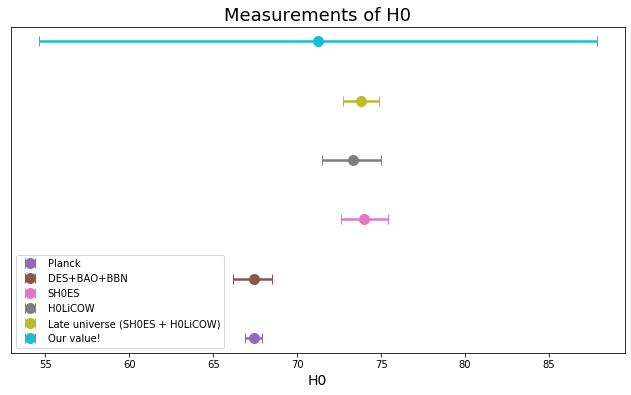

H0 = 71.21491806847467


In [400]:
other_h0_values = [67.4, 67.4, 74.0, 73.3, 73.8, h0_stats['center'][0]]
errors = [[0.5, 1.2, 1.4, 1.8, 1.1, h0_stats['width'][0]], [0.5, 1.1, 1.4, 1.7, 1.1, h0_stats['width'][0]]]
y = [1, 2, 3, 4, 5, 6]
names = ['Planck', 'DES+BAO+BBN', 'SH0ES', 'H0LiCOW', 'Late universe (SH0ES + H0LiCOW)', 'Our value!']

plt.figure(figsize=(11,6))

for i in range(0, len(y)):
    plt.errorbar(other_h0_values[i], y[i], xerr=[[errors[0][i]], [errors[1][i]]], linestyle='', marker='o', 
                 capsize=5, label=names[i], markersize=10, linewidth=2.5, color = 'C' + str(i+4))
plt.legend()
plt.xlabel('H0', fontsize=14)
plt.title('Measurements of H0', fontsize=18)
plt.yticks([], [])
plt.show()

print('H0 = ' + str(h0_stats['center'][0]))

## H0

{'mode': 67.66311209652712,
 'level': array([0.68268949, 0.95449974]),
 'prob': array([0.68294093, 0.95527227]),
 'density': array([0.01223184, 0.00257748]),
 'min': array([53.35775753, 42.23137065]),
 'max': array([ 88.32640202, 117.57290469]),
 'low': array([-14.30535457, -25.43174145]),
 'high': array([20.66328993, 49.90979259]),
 'center': array([70.84207978, 79.90213767]),
 'width': array([17.48432225, 37.67076702])}

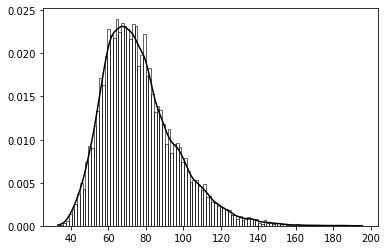

In [392]:
n_h0 = whist(h0_mcmc, plot=plt, color='black')
h0_stats

# Making the plot comparing H0 posteriors for different kT biases
#fig, ax = plt.subplots()
#n_h0 = whist(h0_mcmc, plot=plt, label='$b_{kT}=norm(\mu=0.09, \sigma=0.13)$', color='black')
#n_h00 = whist(h0_mcmc0, plot=plt, label='$b_{kT}=0.0$', color='red')
#n_h09 = whist(h0_mcmc9, plot=plt, label='$b_{kT}=0.09$', color='cyan')
#plt.legend(fontsize=12)
#ax.tick_params(direction='inout', length=8)
#ax.xaxis.set_minor_locator(MultipleLocator(5))
#ax.yaxis.set_minor_locator(MultipleLocator(0.0025))
#plt.xlabel('$H_0$', fontsize=16)
#plt.figure(figsize=(10,6))
#fig.savefig('/Users/jwan/Documents/research 2020/plots for paper/H0_pdfs.jpeg')

## Omega_m

In [241]:
#n_om = whist(om, plot=plt)
#om_stats

## Intrinsic scatter

{'mode': 0.11183940243776674,
 'level': array([0.68268949, 0.95449974]),
 'prob': array([0.68566353, 0.95451776]),
 'density': array([6.26324079, 1.2428792 ]),
 'min': array([0.08699705, 0.065467  ]),
 'max': array([0.16152412, 0.22445808]),
 'low': array([-0.02484236, -0.0463724 ]),
 'high': array([0.04968471, 0.11261868]),
 'center': array([0.12426058, 0.14496254]),
 'width': array([0.03726353, 0.07949554])}

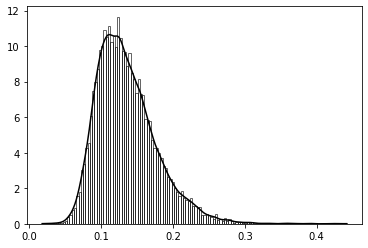

In [393]:
n_scatter = whist(int_scatter, plot=plt, color='black')
int_scatter_stats

## kT bias

{'mode': 0.08389566320852349,
 'level': array([0.68268949, 0.95449974]),
 'prob': array([0.68451566, 0.95529041]),
 'density': array([1.82764128, 0.45989079]),
 'min': array([-0.04572233, -0.16390344]),
 'max': array([0.2154198 , 0.34694394]),
 'low': array([-0.12961799, -0.24779911]),
 'high': array([0.13152414, 0.26304828]),
 'center': array([0.08484874, 0.09152025]),
 'width': array([0.13057107, 0.25542369])}

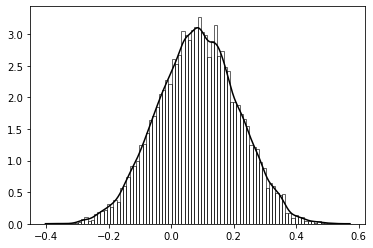

In [394]:
n_kt = whist(kt_bias, plot=plt, color='black')
kt_bias_stats

# Making the plot comparing kT bias posterior distributions for the two H0 priors
#fig, ax = plt.subplots()
#n_kt = whist(kt_bias, plot=plt, label='Planck 2018 prior\n$H_0=norm(\mu=67.4, \sigma=0.5)$', color='black')
#n_kt0 = whist(kt_bias0, plot=plt, label='Riess 2019 prior\n$H_0=norm(\mu=74.03, \sigma=1.42)$', color='red')
#plt.legend(fontsize=12)
#ax.tick_params(direction='inout', length=8)
#ax.xaxis.set_minor_locator(MultipleLocator(0.025))
#ax.yaxis.set_minor_locator(MultipleLocator(0.25))
#plt.xlabel('$b_{kT}$', fontsize=16)
#plt.figure(figsize=(10,6))
#fig.savefig('/Users/jwan/Documents/research 2020/plots for paper/kT_pdfs.jpeg')

## Fit/flux bias

{'mode': 0.025481117715729446,
 'level': array([0.68268949, 0.95449974]),
 'prob': array([0.68299018, 0.95459229]),
 'density': array([9.51977076, 1.88274193]),
 'min': array([-0.00160161, -0.02909468]),
 'max': array([0.04969144, 0.07472244]),
 'low': array([-0.02708273, -0.0545758 ]),
 'high': array([0.02421032, 0.04924132]),
 'center': array([0.02404491, 0.02281388]),
 'width': array([0.02564652, 0.05190856])}

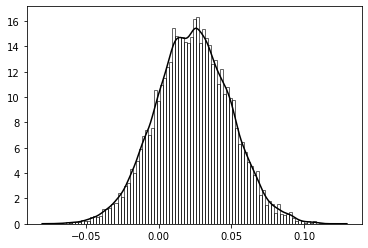

In [129]:
n_f = whist(f_bias, plot=plt, color='black')
f_bias_stats

## 2-D plots

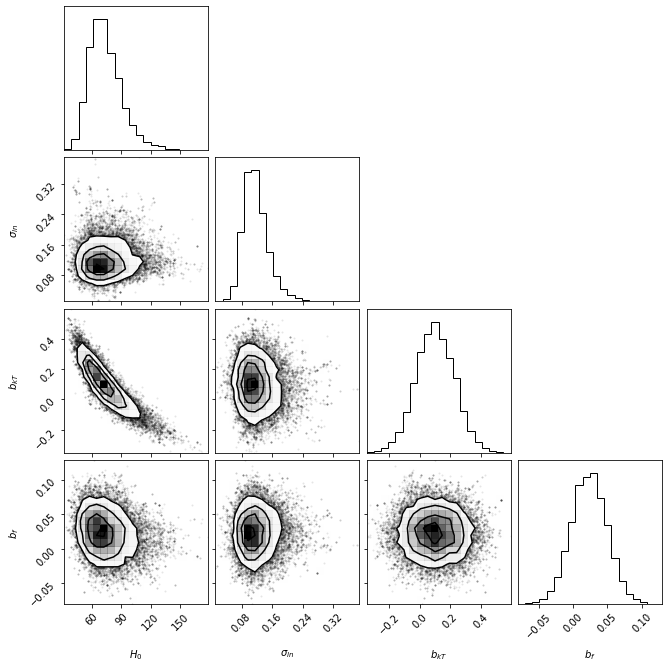

In [10]:
data = []
for i in range(0, len(h0_mcmc)):
    data.append([h0_mcmc[i], int_scatter[i], kt_bias[i], f_bias[i]])
data = np.array(data)    
figure = corner.corner(data, labels=['$H_0$', '$\sigma_{ln}$', '$b_{kT}$', '$b_f$'])
#figure.savefig('/Users/jwan/Documents/research 2020/plots for paper/triangle.jpeg')

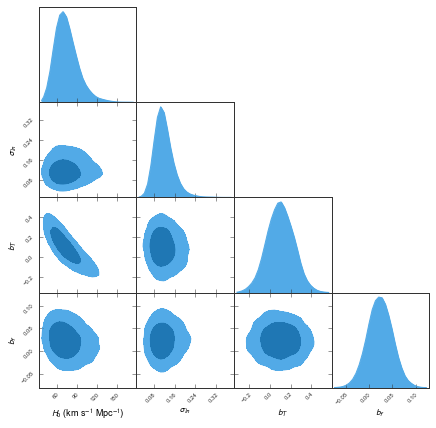

In [24]:
names = ['$H_0$ (km s$^{-1}$ Mpc$^{-1}$)',
         '$\sigma_{ln}$',
         '$b_{T}$', 
         '$b_{f}$']
GTC = pygtc.plotGTC(chains=[data], figureSize='MNRAS_page', paramNames=names, plotName='fullGTC.pdf')

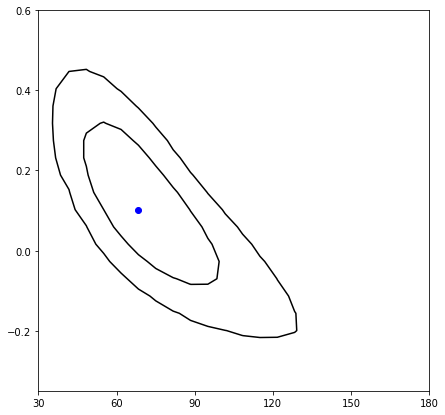

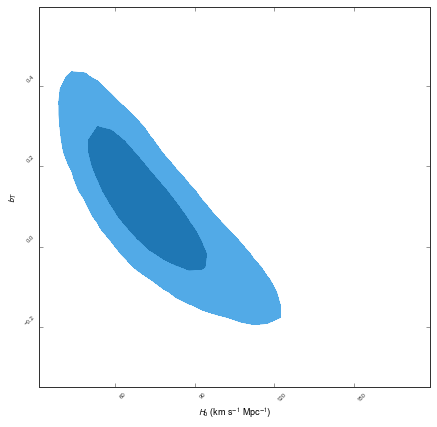

In [116]:
h = whist2d(h0_mcmc, kt_bias, smooth=1, bins=22)
fig, ax = plt.subplots(figsize=(7,7))
ax.xaxis.set_major_locator(MultipleLocator(30))
plt.ylim(-0.35, 0.6)
plt.xlim(30, 180)
contour = whist2d_ci(h, plot=plt)

names = ['$H_0$ (km s$^{-1}$ Mpc$^{-1}$)',
         '$b_{T}$']

data2 = []
for i in range(0, len(h0_mcmc)):
    data2.append([h0_mcmc[i], kt_bias[i]])
data2 = np.array(data2)   

GTC = pygtc.plotGTC(chains=[data2], figureSize='MNRAS_page', paramNames=names, do1dPlots=False) 
                    #plotName='H0_kT.pdf')

In [380]:
# reference cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

data = Table.read('unblinded_data_for_likelihood_final.dat', format='ascii')

# reference distance
d_ref = coord.Distance(z=data['redshift'], cosmology=cosmo)

In [381]:
log_errors = [0.03488536882171687, 0.038431549324005165, 0.07054106161422483, 0.03386533360680443, 
              0.05954415352940518, 0.07421565870592091, 0.09540063907361875, 0.12391542144090344, 
              0.10699553676491845, 0.11241871799853413, 0.1442602067392192, 0.19827686070271094, 
              0.10867795544648474, 0.2219698317811953]

kT_bias = 0.10
f_bias = 0.024
intr_scatter = 0.11

# angular diameter distance from s_obs
dz = d_ref/((np.exp(data['s_obs'] - f_bias) / (1 + data['kt_scale'] * kT_bias))**2)
DA = dz/((1 + data['redshift'])**2)

# angular diameter distance from s_obs - error
dz_err_pos = d_ref/((np.exp(np.array(data['s_obs'] - log_errors) - f_bias) / (1 + data['kt_scale'] * kT_bias))**2)
DA_err_pos = dz_err_pos/((1 + data['redshift'])**2)

# angular diameter distance from s_obs + error
dz_err_neg = d_ref/((np.exp(np.array(data['s_obs'] + log_errors) - f_bias) / (1 + data['kt_scale'] * kT_bias))**2)
DA_err_neg = dz_err_neg/((1 + data['redshift'])**2)

# differences
neg_err = [DA - DA_err_neg][0].value
pos_err = [DA_err_pos - DA][0].value

# reference
ref = coord.Distance(z=np.linspace(0.02, 0.7, 100), cosmology=cosmo)/((1 + np.linspace(0.02, 0.7, 100))**2)

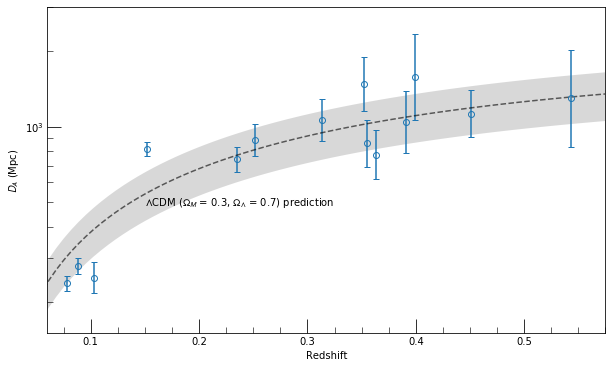

In [385]:
fig, ax = plt.subplots(figsize=(10,6))
plt.errorbar(data['redshift'], DA.value, [neg_err, pos_err], linestyle='', marker='o', capsize=3, fillstyle='none')
plt.plot(np.linspace(0.02, 0.7, 100), ref, linestyle='dashed', color='black', alpha=0.6)
ax.fill_between(np.linspace(0.02, 0.7, 100), ref*(1-2*intr_scatter), ref*(1+2*intr_scatter), facecolor='grey', alpha=0.3)
plt.xlabel('Redshift')
plt.ylabel('$D_A$ (Mpc)')
ax.tick_params(direction='in', length=14)
ax.tick_params(which='minor', direction='in', length=6)
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
plt.xlim(0.06, 0.575)
plt.ylim(1.5e+2, 3e+3)
plt.yscale('log')
plt.annotate('$\Lambda$CDM ($\Omega_M$ = 0.3, $\Omega_\Lambda$ = 0.7) prediction', 
             (0.15, 0.9*coord.Distance(z=0.15, cosmology=cosmo).value/((1 + 0.15)**2)), 
             ha='left')
#plt.savefig('/Users/jwan/Documents/research 2020/plots for paper/DA_vs_z_new.png')
plt.show()